# Newton-Raphson method
https://mmas.github.io/newton-julia   
Newton-Raphson method (or Newton's method) is a method to find the **root** of a **real** function. Knowing the **function and its derivative**, it will calculate successive approximations to the root from an initial guess, calculating the x-intercept of the tangent line of this guess and using x-intercept value as the new guess for the next iteration. The process will continue till the computed value is accurate enough, according to a tolerance parameter.   

The x-intercept of the tangent line of $f(x_n)$ is 
$$0=f^\prime(x_n)(x_{n+1}-x_n)+f(x_n)$$
Solving for $x_{n+1}$ gives the new approximation
$$ x_{n+1} = x_n - \frac{f(x_n)}{f^\prime(x_n)}$$

In [9]:
function newton(f::Function, x0::Number, fprime::Function, args::Tuple=();
                tol::AbstractFloat=1e-8, maxiter::Integer=50, eps::AbstractFloat=1e-10)
    for _ in 1:maxiter
        yprime = fprime(x0, args...)
        if abs(yprime) < eps
            println("Warning:First derivative is zero")
            return x0
        end
        y = f(x0, args...)
        x1 = x0 - y/yprime
        if abs(x1-x0) < tol
            return x1
        end
        x0 = x1
    end
    error("Max iteration exceeded")
end

newton (generic function with 2 methods)

In [14]:
f(x) = x^2 - 1
fprime(x) = 2x
x0 = 1
newton(f,x0,fprime)

1.0

In [11]:
begin
    f(x) = x^2 - 2
    fprime(x) = 2x
    x0 = 0
    newton(f,x0,fprime)
end
nothing

In [16]:
begin
    x = 1
    x += 1
end
@show x

x = 2


2

In [12]:
(f(x)=x^2-2; fprime(x)=2x; x0=-1; newton(f,x0,fprime))

-1.4142135623730951

# Molecular dynamics
We choose the **Verlet** algorithm for the MD simulation to update at the j-th step:
$$ u^{j+1} = u^{j} + \Delta t_m \dot{u}^j + \frac12 \Delta t^2_m\ddot{u}^j$$
$$ \dot{u}^{j+1/2}=\dot{u}^j+\frac12\Delta t_m\ddot{q}^j$$
$$ \ddot{u}^{j+1}=-\frac{\partial U}{\partial u} + f_\textrm{ext}^j$$
$$ \dot{u}^{j+1} = \dot{u}^{j+1/2}+\frac12\Delta t_m \ddot{u}^{j+1}$$   

Consider a atomistic chain with the **Lennard-Jones (LJ)** potential function as the nearest neighboring atom interaction:
$$ U(r_{ij}) = 4\left[ \left(\frac{1}{r_{ij}}\right)^{12} - \left( \frac{1}{r_{ij}}\right) \right]$$
with initial displacement
$$ u(x,t=0) = \left\{
\begin{array}[cc]
    sA e^{(x/\sigma)^2}[1+b\cos(\frac{2\pi x}{H})] & |x|\leq L_c\\
    0 & |x|>L_c
\end{array}
\right.
$$

In [17]:
using JuLIP
using PyPlot

In [19]:
L = 300
r0 = 1
x = collect(range(-L, stop=L)) .* r0
X = zeros(Float64, 3, length(x))
X[1,:] = x
X0 = deepcopy(X)
at = Atoms(:X, X)

lj = lennardjones(; r0=r0)
set_calculator!(at, lj)
set_pbc!(at, [true, false, false])
mask = fill(false, 3, length(at))
mask[1, :] .= true
set_mask!(at, mask)

T = 15
Δt = 0.002
n = convert(Int64, T/Δt)
N = 2*L+1
σ = 20
H = σ/4
A = 0.01
b = 0.2
Lc = 80

# initial displacement
u = zeros(Float64, N, n)
IcIdx = collect(-Lc:Lc)
IcUIdx = IcIdx .+ div(N+1,2)
u[IcUIdx, 1] = A*( exp.( -(IcIdx./σ).^2 )).*( 1 .+b.*cos.(2π.*IcIdx./H) )
nothing

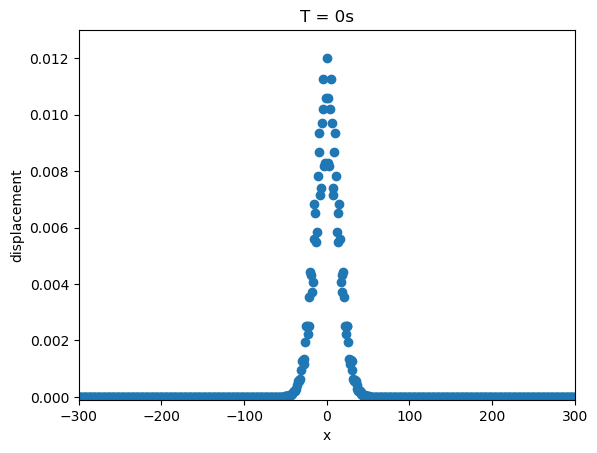

In [35]:
scatter(collect(range(-L, stop=L)), u[:,1])
xlabel("x")
ylabel("displacement")
title("T = 0s")
axis([-300, 300, -0.0001, 0.013])
nothing

In [25]:
X[1,:] = X0[1,:] + u[:,1]
set_positions!(at, X)
v = zeros(Float64, N, n)
a = zeros(Float64, N, n)

frc = forces(at) |> mat
a[:,1] = frc[1,:]

for t = 1:(n-1)
    u[:,t+1] = u[:,t] .+ v[:,t] .* Δt .+ a[:,t] .* (Δt)^2/2
    X[1,:] = X0[1,:] + u[:,t+1]
    # X[1,:] = u[:,t+1]
    set_positions!(at, X)
    # set_dofs!(at, X[:,1])
    # w[:,t] = v[:,t] .+ a[:,t] .* (Δt)^2/2

    frc =  forces(at) |> mat
    a[:,t+1] = frc[1,:]

    v[:,t+1] = v[:,t] .+ a[:,t] .* (Δt)/2 .+ a[:,t+1] .* (Δt)/2
end

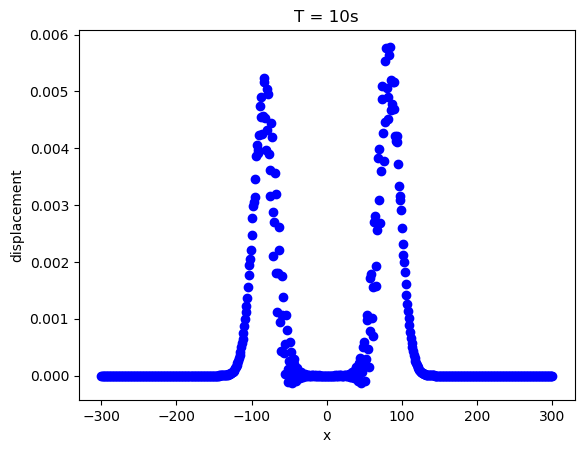

PyObject Text(0.5, 1.0, 'T = 10s')

In [92]:
PyPlot.figure
plot(collect(range(-L, stop=L)), u[:,5000], "bo")
xlabel("x")
ylabel("displacement")
title("T = 10s")

In [38]:
?range

search: range LinRange UnitRange StepRange StepRangeLen trailing_zeros



```
range(start[, stop]; length, stop, step=1)
```

Given a starting value, construct a range either by length or from `start` to `stop`, optionally with a given step (defaults to 1, a [`UnitRange`](@ref)). One of `length` or `stop` is required.  If `length`, `stop`, and `step` are all specified, they must agree.

If `length` and `stop` are provided and `step` is not, the step size will be computed automatically such that there are `length` linearly spaced elements in the range (a [`LinRange`](@ref)).

If `step` and `stop` are provided and `length` is not, the overall range length will be computed automatically such that the elements are `step` spaced (a [`StepRange`](@ref)).

`stop` may be specified as either a positional or keyword argument.

!!! compat "Julia 1.1"
    `stop` as a positional argument requires at least Julia 1.1.


# Examples

```jldoctest
julia> range(1, length=100)
1:100

julia> range(1, stop=100)
1:100

julia> range(1, step=5, length=100)
1:5:496

julia> range(1, step=5, stop=100)
1:5:96

julia> range(1, 10, length=101)
1.0:0.09:10.0

julia> range(1, 100, step=5)
1:5:96
```

---

```
range(start::T; stop::T, length=100) where T<:Colorant
range(start::T, stop::T; length=100) where T<:Colorant
```

Generates N (=`length`) >2 colors in a linearly interpolated ramp from `start` to`stop`, inclusive, returning an `Array` of colors.

!!! compat "Julia 1.1"
    `stop` as a positional argument requires at least Julia 1.1.



In [43]:
using Printf

In [46]:
@sprintf("T = %3.1fs", Δt*100)

"T = 0.2s"

In [90]:
for i = range(100, stop=5000,step=100)
    plot(collect(range(-L, stop=L)), u[:,i])
    xlabel("x")
    ylabel("displacement")
    stitle = @sprintf("T = %3.1fs", Δt*i)
    title(stitle)
    axis([-300, 300, -0.0001, 0.013])
    fstr = @sprintf("./plots/t%03d.png", convert(Int64, ceil(Δt*i*10)))
    savefig(fstr)
    plt.clf()
end

In [91]:
run(`convert -delay 10 ./plot*.png -loop 0 chain.gif`)

┌ Warning: Parsing command "convert -delay 10 ./plot*.png -loop 0 chain.gif". Special characters "#{}()[]<>|&*?~;" should now be quoted in commands
│   caller = #shell_parse#350(::String, ::typeof(Base.shell_parse), ::String, ::Bool) at shell.jl:107
└ @ Base ./shell.jl:107
convert: unable to open image `./plot*.png': No such file or directory @ error/blob.c/OpenBlob/2761.
convert: no images defined `chain.gif' @ error/convert.c/ConvertImageCommand/3258.


ProcessFailedException: failed process: Process(`convert -delay 10 './plot*.png' -loop 0 chain.gif`, ProcessExited(1)) [1]
